In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install git+https://github.com/huggingface/transformers.git # Install from source for latest LLaMA support
# !pip install datasets accelerate bitsandbytes peft

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("WARNING: GPU not detected")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Ti
Memory Usage: 0.00 GB / 7.65 GB


In [ ]:
from huggingface_hub import login
login(token="your token")

In [4]:
from transformers import AutoProcessor, AutoTokenizer

VISION_MODEL_ID = "openai/clip-vit-base-patch32"
LLM_MODEL_ID = "meta-llama/Llama-3.2-1B"

image_processor = AutoProcessor.from_pretrained(VISION_MODEL_ID, use_fast=True)


tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID)


tokenizer.pad_token = tokenizer.eos_token
print("Processors loaded successfully.")

Processors loaded successfully.


In [5]:
# import os

# # Download the text files (approx 2MB)
# !wget -q https://github.com/Avaneesh40585/Flickr8k-Dataset/releases/download/v1.0/Flickr8k_text.zip
# !unzip -q -o Flickr8k_text.zip

# print("Download complete. You should see 'Flickr8k.token.txt' in your files.")

In [6]:
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !unzip -q -o Flickr8k_Dataset

In [7]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

IMAGES_DIR = os.path.expanduser("./Flicker8k_Dataset/")
CAPTIONS_FILE = "Flickr8k.token.txt"

class Flickr8kDataset(Dataset):
    def __init__(self, images_dir, captions_file):
        self.images_dir = images_dir
        self.data = []
        
        # Parse the unique Flickr8k format: "image.jpg#0 caption"
        with open(captions_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 2:
                    parts = line.strip().split(' ', 1)
                
                if len(parts) >= 2:
                    image_id_raw, caption = parts[0], parts[1]
                    # Remove the #0, #1 tag from filename (e.g., image.jpg#0 -> image.jpg)
                    image_file = image_id_raw.split('#')[0]
                    self.data.append((image_file, caption))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_file, caption = self.data[idx]
        image_path = os.path.join(self.images_dir, image_file)
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            # fallback, just in case
            image = Image.new('RGB', (224, 224), color='gray')

        prefix = "USER: <image>\nDescribe this image.\nASSISTANT: "
        full_text = f"{prefix}{caption}"
        
        return {
            "image": image, 
            "caption": full_text,
            "original_caption": caption
        }

dataset = Flickr8kDataset(IMAGES_DIR, CAPTIONS_FILE)

# create a small subset for testing
shuffled_dataset = [dataset[i] for i in range(0, 500, 5)]

print(f"Dataset Loaded. Found {len(dataset)} captions.")

Dataset Loaded. Found 40460 captions.


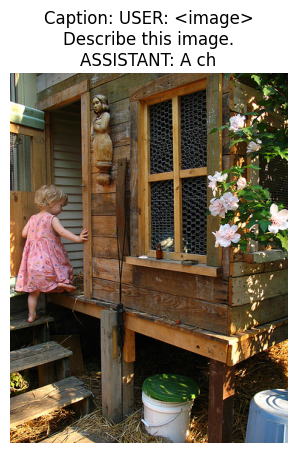

Phase 1 Complete: Local Images + Downloaded Captions are working!


In [8]:
import matplotlib.pyplot as plt

sample = shuffled_dataset[0]
image = sample['image']
caption = sample['caption']

plt.imshow(image)
plt.axis("off")
plt.title(f"Caption: {caption[:50]}")
plt.show()

# ensure 'image_processor' and 'tokenizer' are loaded from Phase 1
def prepare_sample(sample):
    img = sample['image']
    text = sample['caption']
    
    pixel_values = image_processor(images=img, return_tensors="pt").pixel_values
    text_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=30)
    
    return pixel_values, text_inputs

pv, ti = prepare_sample(sample)

if pv.shape == (1, 3, 224, 224):
    print("Phase 1 Complete: Local Images + Downloaded Captions are working!")
else:
    print("Issue with image loading.")

In [9]:
#Phase2

In [10]:
import torch
from transformers import LlamaForCausalLM, BitsAndBytesConfig

# use bfloat16 to prevent nans
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  
    bnb_4bit_use_double_quant=True
)

llm_model = LlamaForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B",
    quantization_config=bnb_config, 
    device_map="auto"
)

from peft import prepare_model_for_kbit_training
llm_model = prepare_model_for_kbit_training(llm_model)

print("LLaMA loaded in 4-bit (BFloat16 Compute)")

Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

LLaMA loaded in 4-bit (BFloat16 Compute)


In [11]:
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    # Separate Images and Texts
    images = [item['image'] for item in batch]
    captions = [item['caption'] for item in batch]
    
    pixel_values = image_processor(images=images, return_tensors="pt").pixel_values
    
    text_inputs = tokenizer(
        captions, 
        padding=True, 
        truncation=True, 
        max_length=64, 
        return_tensors="pt"
    )
    
    input_ids = text_inputs.input_ids
    attention_mask = text_inputs.attention_mask
    
    labels = input_ids.clone()
    
    # masking padding tokens so they don't affect the loss
    # replacing the padding token ID with -100, which pytorch ignores
    labels[attention_mask == 0] = -100 
    
    return {
        "pixel_values": pixel_values.to("cuda"),
        "input_ids": input_ids.to("cuda"),
        "attention_mask": attention_mask.to("cuda"),
        "labels": labels.to("cuda")
    }

train_loader = DataLoader(
    dataset, 
    batch_size=8,          
    shuffle=True,          
    collate_fn=collate_fn
)

# Test a single batch to ensure shapes are correct
sample_batch = next(iter(train_loader))
print("Pixel Values Shape:", sample_batch['pixel_values'].shape)
print("Input IDs Shape:", sample_batch['input_ids'].shape)

Pixel Values Shape: torch.Size([8, 3, 224, 224])
Input IDs Shape: torch.Size([8, 31])


In [12]:
from transformers import CLIPVisionModel


vision_tower = CLIPVisionModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    torch_dtype=torch.bfloat16, 
    low_cpu_mem_usage=True
).to("cuda")

for param in vision_tower.parameters():
    param.requires_grad = False

print("CLIP loaded and frozen (BFloat16).")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

CLIPVisionModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.encoder.layers.{0...11}.self_attn.out_proj.weight | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.weight            | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.out_proj.bias   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.v_proj.bias 

CLIP loaded and frozen (BFloat16).


In [13]:
import torch
import torch.nn as nn

class SimpleVLM(nn.Module):
    def __init__(self, vision_tower, llm_model):
        super().__init__()
        self.vision_tower = vision_tower
        self.llm = llm_model
        
        vision_dim = vision_tower.config.hidden_size 
        text_dim = llm_model.config.hidden_size      
        
        self.projector = nn.Sequential(
            nn.Linear(vision_dim, text_dim),
            nn.GELU(),
            nn.Linear(text_dim, text_dim)
        )
        
        
        self.projector.to(device="cuda", dtype=torch.bfloat16)

    def forward(self, pixel_values, input_ids, attention_mask=None, labels=None):
        
        if pixel_values.dtype != torch.bfloat16:
            pixel_values = pixel_values.to(dtype=torch.bfloat16)

        # VISUAL ENCODING
        with torch.no_grad():
            vision_outputs = self.vision_tower(pixel_values)
            image_embeds = vision_outputs.last_hidden_state
            
        # PROJECTION
        # Ensure input to projector is bfloat16
        image_embeds_proj = self.projector(image_embeds.to(dtype=torch.bfloat16))
        
        # TEXT EMBEDDING
        text_embeds = self.llm.model.embed_tokens(input_ids)
        
        # ensure text is bfloat16
        if text_embeds.dtype != torch.bfloat16:
            text_embeds = text_embeds.to(dtype=torch.bfloat16)

        # CONCATENATION
        inputs_embeds = torch.cat([image_embeds_proj, text_embeds], dim=1)
        
        #  ATTENTION MASK HANDLING
        if attention_mask is not None:
            batch_size = inputs_embeds.shape[0]
            num_image_tokens = image_embeds_proj.shape[1]
            image_mask = torch.ones((batch_size, num_image_tokens), device=attention_mask.device)
            full_attention_mask = torch.cat([image_mask, attention_mask], dim=1)
        else:
            full_attention_mask = None

        #  LABEL HANDLING
        if labels is not None:
            batch_size = inputs_embeds.shape[0]
            num_image_tokens = image_embeds_proj.shape[1]
            image_labels = torch.full((batch_size, num_image_tokens), -100, device=labels.device)
            full_labels = torch.cat([image_labels, labels], dim=1)
        else:
            full_labels = None

        # FINAL PASS
        outputs = self.llm(
            inputs_embeds=inputs_embeds,
            attention_mask=full_attention_mask,
            labels=full_labels
        )
        return outputs

# Re-instantiate
vlm_model = SimpleVLM(vision_tower, llm_model)
print("VLM Model updated with strict BFloat16 casting")

VLM Model updated with strict BFloat16 casting


In [14]:
import torch.optim as optim
from tqdm import tqdm
import os

# Reset Model
# We re-initialize the projector to clear previous weights
vlm_model = SimpleVLM(vision_tower, llm_model)

# Setup Optimizer
# We focus ONLY on the projector parameters
optimizer = optim.AdamW(vlm_model.projector.parameters(), lr=1e-4)

# Settings
epochs = 3
save_path = "simple_vlm_projector_3epochs.pth"

print(f" Starting Extended Training (3 Epochs)")
vlm_model.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", mininterval=1.0)
    
    for step, batch in enumerate(progress_bar):
        
        # Forward Pass
        outputs = vlm_model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        
        loss = outputs.loss
        loss.backward()
        
        # Optimization (Gradient Clipping to prevent crash)
        torch.nn.utils.clip_grad_norm_(vlm_model.projector.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        current_loss = loss.item()
        epoch_loss += current_loss
        progress_bar.set_postfix(loss=f"{current_loss:.4f}")

    # End of Epoch Stats
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} Complete. Average Loss: {avg_loss:.4f}")
    
    # Save Checkpoint after every epoch 
    torch.save(vlm_model.projector.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

# Final Save
torch.save(vlm_model.projector.state_dict(), save_path)
print(f"Training Finished! Final weights saved to {save_path}")

 Starting Extended Training (3 Epochs)


Epoch 1/3:   0%|                                                                                                                             | 0/5058 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/lalit/models/ghostnet/llava/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 1/3:   1%|▋                                                                                                      | 34/5058 [00:14<35:38,  2.35it/s, loss=1.7924]


KeyboardInterrupt: 

In [ ]:
torch.save(vlm_model.projector.state_dict(), "simple_vlm_projector_final.pth")
print("Weights saved safely.")

In [ ]:
# INFERENCE

In [ ]:
import torch
from PIL import Image

def generate_caption(image_path):
    vlm_model.eval()
    
    # Standard Prompt
    prompt = "USER: <image>\nDescribe this image.\nASSISTANT:"
    
    # Process Image
    image = Image.open(image_path).convert("RGB")
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to("cuda")
    
    # Ensure inputs are bfloat16
    pixel_values = pixel_values.to(dtype=torch.bfloat16)

    with torch.no_grad():
        # Get CLIP features
        vision_outputs = vlm_model.vision_tower(pixel_values)
        image_embeds = vision_outputs.last_hidden_state
        
        # Explicitly cast to bfloat16 before feeding to the projector
        image_embeds = image_embeds.to(dtype=torch.bfloat16) 
        
        # Project to LLaMA space
        image_embeds_proj = vlm_model.projector(image_embeds)

    # Process Text
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    
    with torch.no_grad():
        text_embeds = vlm_model.llm.model.embed_tokens(input_ids)
        # Ensure text embeddings are also bfloat16
        text_embeds = text_embeds.to(dtype=torch.bfloat16)

    # Concatenate
    inputs_embeds = torch.cat([image_embeds_proj, text_embeds], dim=1)
    attention_mask = torch.ones(inputs_embeds.shape[:2], dtype=torch.long, device="cuda")

    # Generate
    print("Generating")
    outputs = vlm_model.llm.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        max_new_tokens=40,       # change according to required output
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Inference function updated")

In [ ]:
import matplotlib.pyplot as plt
import random


random_idx = random.randint(0, len(dataset))
sample = dataset[random_idx]
image_path = os.path.join(dataset.images_dir, dataset.data[random_idx][0])


plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()


generated_text = generate_caption(image_path)

print("-" * 30)
print(f"Ref Caption: {sample['original_caption']}")
print(f"Model Says: {generated_text}")
print("-" * 30)

In [ ]:
# EVALUATION

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
import torch
from tqdm import tqdm
import random
from collections import defaultdict

def evaluate_model(dataset, num_samples=50):
    print(f"📊 Starting Evaluation on {num_samples} random images...")
    
    # 1. Regroup Dataset (Image -> List of Captions)
    # We need all 5 ground truth captions for each image to calculate accurate BLEU.
    image_to_captions = defaultdict(list)
    unique_images = []
    

    for img_file, caption in dataset.data:
        image_to_captions[img_file].append(caption)
        if img_file not in unique_images:
            unique_images.append(img_file)
    
    # 2. Select Random Subset

    if num_samples > len(unique_images):
        num_samples = len(unique_images)
    
    test_images = random.sample(unique_images, num_samples)
    
    references = []  # List of lists of valid captions [[ref1a, ref1b...], [ref2a...]]
    hypotheses = []  # List of our generated captions [gen1, gen2...]
    
    vlm_model.eval()
    
    # 3. Inference Loop
    for image_file in tqdm(test_images):


        # Structure: [ ['a', 'cat'], ['the', 'cat'] ]
        refs = [c.lower().split() for c in image_to_captions[image_file]]
        references.append(refs)
        

        image_path = os.path.join(dataset.images_dir, image_file)
        

        try:
            generated_text = generate_caption(image_path) 
            

            if "ASSISTANT:" in generated_text:
                generated_text = generated_text.split("ASSISTANT:")[-1]
            

            hypotheses.append(generated_text.lower().split())
            
        except Exception as e:
            print(f"Error generating for {image_file}: {e}")
            # Add empty placeholder to keep lists aligned
            hypotheses.append(["<error>"])


    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    print("\n" + "="*30)
    print(f"✅ Evaluation Complete")
    print(f"BLEU-1 Score: {bleu_1*100:.2f}")
    print(f"BLEU-4 Score: {bleu_4*100:.2f}")
    print("="*30)
    

    print("\nExample Comparison:")
    for i in range(3):
        print(f"Ref: {' '.join(references[i][0])}") # Show just the first ref
        print(f"Gen: {' '.join(hypotheses[i])}")
        print("-" * 20)


evaluate_model(dataset, num_samples=50)

In [ ]:
# REGION SPECIFIC DETECTION

In [ ]:
import torch
from PIL import Image

def generate_caption(image_input, prompt_text="Describe this image."):
    vlm_model.eval()
    
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB")
    else:
        image = image_input.convert("RGB")
        
    #  Standard Prompt Template
    # We use the same template we trained with
    full_prompt = f"USER: <image>\n{prompt_text}\nASSISTANT:"
    
    #  Process Image
    # CLIP Processor handles resizing/normalizing the crop automatically
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to("cuda")
    pixel_values = pixel_values.to(dtype=torch.bfloat16) # Cast to bfloat16

    with torch.no_grad():
        # Visual Encoder (CLIP)
        vision_outputs = vlm_model.vision_tower(pixel_values)
        image_embeds = vision_outputs.last_hidden_state.to(dtype=torch.bfloat16)
        
        # Projector
        image_embeds_proj = vlm_model.projector(image_embeds)

    #  Process Text
    inputs = tokenizer(full_prompt, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    
    with torch.no_grad():
        text_embeds = vlm_model.llm.model.embed_tokens(input_ids).to(dtype=torch.bfloat16)

    #  Concatenate
    inputs_embeds = torch.cat([image_embeds_proj, text_embeds], dim=1)
    attention_mask = torch.ones(inputs_embeds.shape[:2], dtype=torch.long, device="cuda")

    #  Generate
    outputs = vlm_model.llm.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        max_new_tokens=40,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("flexible generate_caption ready (accepts PIL images).")

In [ ]:
def get_region_caption(image_path, region_prompt):

    orig_image = Image.open(image_path).convert("RGB")
    w, h = orig_image.size
    
    # Default to full image
    crop = orig_image
    region_name = "Full Image"
    
    prompt_lower = region_prompt.lower()
    
    if "top-left" in prompt_lower or "top left" in prompt_lower:
        crop = orig_image.crop((0, 0, w//2, h//2))
        region_name = "Top-Left Corner"
        
    elif "top-right" in prompt_lower or "top right" in prompt_lower:
        crop = orig_image.crop((w//2, 0, w, h//2))
        region_name = "Top-Right Corner"
        
    elif "bottom-left" in prompt_lower or "bottom left" in prompt_lower:
        crop = orig_image.crop((0, h//2, w//2, h))
        region_name = "Bottom-Left Corner"
        
    elif "bottom-right" in prompt_lower or "bottom right" in prompt_lower:
        crop = orig_image.crop((w//2, h//2, w, h))
        region_name = "Bottom-Right Corner"
        
    elif "center" in prompt_lower:
        # Take the center 50%
        left = w // 4
        top = h // 4
        right = 3 * w // 4
        bottom = 3 * h // 4
        crop = orig_image.crop((left, top, right, bottom))
        region_name = "Center Region"
        
    # We pass the crop to the model. The model just sees "an image".
    # It doesn't know it's a crop, so it describes it fully.
    caption = generate_caption(crop, prompt_text="Describe this object.")
    
    return region_name, crop, caption

print("✅ Region Logic Ready.")

In [ ]:
import matplotlib.pyplot as plt


region_queries = [
    "Describe the full image",
    "Describe the object in the top-left corner",
    "Describe the top-right corner",
    "Describe the center of the image"
]



fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 18)) 

for i, query in enumerate(region_queries):

    r_name, r_crop, r_caption = get_region_caption(image_path, query)
    

    ax = axes[i]
    ax.imshow(r_crop)
    ax.axis("off")
    

    clean_caption = r_caption.split("ASSISTANT:")[-1].strip()
    

    ax.set_title(f"Query: {query}\nRegion: {r_name}\n\n🤖: {clean_caption}", 
                 fontsize=12, loc='left', pad=10)

plt.tight_layout()
plt.show()